In [25]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer,BertConfig,get_linear_schedule_with_warmup,BertForSequenceClassification
from torch.optim.lr_scheduler import StepLR
import torch
import torch.nn as nn 
from torchmetrics.classification import ConfusionMatrix,F1Score
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
import unicodedata
import spacy
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
nltk.download('punkt')
import random
import os
import time
import datetime

def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run. This is for REPRODUCIBILITY.
    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/natedrake7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/natedrake7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Pre-Processing

In [15]:
#Read csv files
train_set = pd.read_csv('./Data/train_set.csv')
valid_set = pd.read_csv('./Data/valid_set.csv')
test_set = pd.read_csv('./Data/test_set.csv')



#Drop Party and New ID columns since we dont need them
labels_to_drop = ['Party','New_ID']
train_set = train_set.drop(columns=labels_to_drop)
valid_set = valid_set.drop(columns=labels_to_drop)
test_set = test_set.drop(columns=['Party'])

train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'#', '', x))
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub(r'#', '', x))
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'#', '', x))

#Remove accents from all text
def strip_accents_and_lowercase(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn').lower()

train_set['Text'] = train_set['Text'].apply(strip_accents_and_lowercase)
valid_set['Text'] = valid_set['Text'].apply(strip_accents_and_lowercase)
test_set['Text'] = test_set['Text'].apply(strip_accents_and_lowercase)

#Remove stopwords and replace them with a single space
stop = stopwords.words('greek')
pat = r'\b(?:{})\b'.format('|'.join(stop))

train_set['Text'] = train_set['Text'].str.replace(pat,'',regex=True)
valid_set['Text'] = valid_set['Text'].str.replace(pat,'',regex=True)
test_set['Text'] = test_set['Text'].str.replace(pat,'',regex=True)

#Remove multiple white spaces and replace them with a single space
train_set['Text'] = train_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces
valid_set['Text'] = valid_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces
test_set['Text'] = test_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces

#Remove links and replace them with a single space
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links

#Replace non greek words with single whitespace
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))      
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))      
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))

#Find retweets and replace them withn single whitespace
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))

#Load lemmatizer
nlp = spacy.load("el_core_news_sm")

def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

#Lemmatize text to replace words with their dictionary value
train_set['Text'] = train_set['Text'].apply(lemmatize_text)
valid_set['Text'] = valid_set['Text'].apply(lemmatize_text)
test_set['Text'] = test_set['Text'].apply(lemmatize_text)

Save To CSV

In [ ]:
train_set.to_csv('processed_df',index=False)
valid_set.to_csv('processed_valid',index=False)
test_set.to_csv('processed_test',index=False)

Read Pre-Processed Data

In [2]:
train_set = pd.read_csv('processed_df')

test_set = pd.read_csv('processed_test')

valid_set = pd.read_csv('processed_valid')

Wordcloud

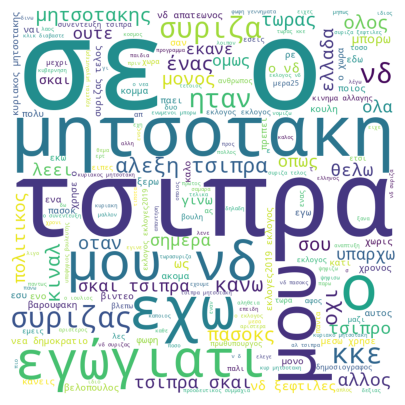

In [18]:
wordcloud = WordCloud(width=800, height=800,background_color='white').generate(' '.join(train_set['Text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Token Frequency

In [21]:
tokens = ' '.join(train_set['Text']).split()
token_counts = Counter(tokens)
print(token_counts.most_common(10))

[('ο', 18186), ('τσιπρα', 9896), ('μου', 8186), ('νδ', 8168), ('μητσοτακη', 6880), ('σε', 4528), ('εκλογος', 4298), ('εχω', 4205), ('συριζα', 3949), ('συριζας', 3630)]


Text Length Distribution

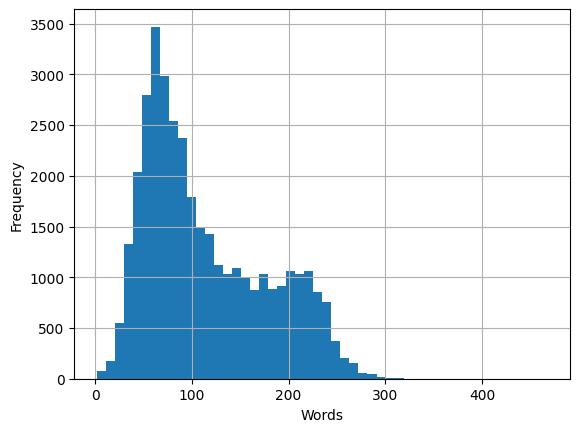

In [22]:
df = train_set.copy()

df['Text'] = df['Text'].apply(len)
df['Text'].hist(bins=50)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

Encode Labels

In [3]:
encoder  = LabelEncoder() #initialize label encoder so we can set integer values to the label unique values

X_train_labels = encoder.fit_transform(train_set['Sentiment']) #Transform the labels
X_valid_labels = encoder.fit_transform(valid_set['Sentiment']) #For both training and validation

print(encoder.classes_)
print(encoder.transform(encoder.classes_))
labels = {0 : 'NEGATIVE',1 : 'NEUTRAL',2 : 'POSITIVE'}

['NEGATIVE' 'NEUTRAL' 'POSITIVE']
[0 1 2]


Import BERT tokenizer

In [4]:
tokenizer = BertTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1", do_lower_case=True)

Find the maximun length of a sentence in all 3 Datasets

In [5]:
max_length = 0

for i,row in enumerate(train_set['Text']):
    train_row_length = len(tokenizer.encode(row, add_special_tokens=True))
    if i < len(test_set):
        test_row_length = len(tokenizer.encode(test_set['Text'][i], add_special_tokens=True))
    if i < len(valid_set):
        valid_row_length = len(tokenizer.encode(valid_set['Text'][i], add_special_tokens=True))
    # Update max_length if the current row's length is greater
    if train_row_length > max_length:
        max_length = train_row_length
    if test_row_length > max_length:
        max_length = test_row_length
    if valid_row_length > max_length:
        max_length = valid_row_length

print(max_length)

91


Tokenize Text

In [6]:
def TokenizeText(data):
    input_ids = []
    attention_masks = []
    for text in data:
        encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = max_length,  
                        padding= 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    return input_ids,attention_masks

train_input_ids,train_attention_masks = TokenizeText(train_set['Text'])
valid_input_ids,valid_attention_masks = TokenizeText(valid_set['Text'])
test_input_ids,test_attention_masks = TokenizeText(test_set['Text'])

Create Tensors

In [7]:
def CreateTensors(input_ids,attentions_masks,labels = None):
    if labels is None:
        return torch.cat(input_ids, dim=0),torch.cat(attentions_masks, dim=0)
    return torch.cat(input_ids, dim=0),torch.cat(attentions_masks, dim=0),torch.tensor(labels)

train_input_ids,train_attention_masks,train_labels = CreateTensors(train_input_ids,train_attention_masks,X_train_labels)
valid_input_ids,valid_attention_masks,valid_labels = CreateTensors(valid_input_ids,valid_attention_masks,X_valid_labels)
test_input_ids,test_attention_masks = CreateTensors(test_input_ids,test_attention_masks)

Create Tensor Datasets

In [8]:
batch_size = 64

train_dataset = TensorDataset(train_input_ids,train_attention_masks,train_labels)
train_dataloader = DataLoader(train_dataset,batch_size = batch_size)

valid_dataset = TensorDataset(valid_input_ids,valid_attention_masks,valid_labels)
valid_dataloader = DataLoader(valid_dataset,batch_size = batch_size)

test_dataset = TensorDataset(test_input_ids,test_attention_masks)
test_dataloader = DataLoader(test_dataset,batch_size = batch_size)

Set Device

In [9]:
if torch.cuda.is_available(): #if nvidia gpu is available
   device="cuda" #set devide to cuda since GPUs are much faster at deep learning
else: 
   device="cpu" #else set CPU
print("Device =",device)

Device = cuda


In [10]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [11]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [12]:
def LearningCurve(training_data,validation_data,plot_label='accuracy',y_label = 'accuracy'):
    epochs = range(1, len(training_data) + 1)
    plt.plot(epochs,training_data, label='Training ' + plot_label)
    plt.plot(epochs,validation_data, label='Validation ' + plot_label)

    plt.xlabel('Epoch')
    plt.ylabel(y_label)

    plt.legend()

    plt.title('Learning Curve')
    
    plt.show()   

In [13]:
def Train(model,dataloader,optimizer,scheduler):
    loss = 0
    total_loss = 0
    total_accuracy = 0
    f1 = 0 #declare f1 score to 0
    f1_score = F1Score(task='multiclass',num_classes=3,average='weighted').to(device)
    counter = 0

    # Measure how long the training epoch takes.
    t0 = time.time()
    for step,batch in enumerate(dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        loss, logits = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels,
                        return_dict=False)
        
        total_loss += loss.item()
        f1+= f1_score(logits.argmax(1),b_labels)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        total_accuracy += flat_accuracy(logits, label_ids)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

        counter+=1

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader)
    avg_f1 = f1 / counter
    training_time = format_time(time.time() - t0)
    
    print("Average training loss: {0:.2f}".format(avg_loss))
    print("Accuracy: {0:.2f}".format(avg_accuracy))
    print("F1-Score: {0:.2f}".format(avg_f1))
    print("Training epoch took: {:}".format(training_time))
    
    return avg_accuracy,avg_f1,avg_loss,training_time

In [14]:
def Validate(model,dataloader):
    t0 = time.time()
    total_eval_accuracy = 0
    total_eval_loss = 0
    f1 = 0 #declare f1 score to 0
    f1_score = F1Score(task='multiclass',num_classes=3,average='weighted').to(device)
    counter = 0
    
    for batch in dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            (loss, logits) = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels,
                            return_dict=False)
            
        total_eval_loss += loss.item()

        f1+= f1_score(logits.argmax(1),b_labels)

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        counter+=1

    avg_val_accuracy = total_eval_accuracy / len(dataloader)
    avg_f1 = f1 / counter
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(dataloader)
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    print("  F1-Score: {0:.2f}".format(avg_f1))
    print("  Validation took: {:}".format(validation_time))

    return avg_val_accuracy,avg_f1,avg_val_loss,validation_time


In [ ]:
def Transformer(input):
    #create a model that uses a bert layer to output the data
    #so bert should output to like 32 and a linear to 3.
    return input

In [26]:
model = BertForSequenceClassification.from_pretrained(
    "nlpaueb/bert-base-greek-uncased-v1",
    num_labels = 3,  
    output_attentions = False,
    output_hidden_states = False,
).to(device)

EPOCHS = 8

optimizer = torch.optim.AdamW(model.parameters(),lr = 2e-6,eps = 1e-8)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
#scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                       num_warmup_steps = 0,
#                                           num_training_steps = len(train_dataloader) * EPOCHS)
training_stats = []
best_f1 = 0

t0 = time.time()
for epoch in range(0,EPOCHS):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, EPOCHS))
    print('Training...')

    model.train()

    avg_train_accuracy,avg_train_f1,avg_train_loss,training_time = Train(model,train_dataloader,optimizer,scheduler)

    model.eval()

    avg_val_accuracy,avg_val_f1,avg_val_loss,validation_time = Validate(model,valid_dataloader)

    if avg_val_f1 >= best_f1:
        best_f1 = avg_val_f1
        best_model = model

    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Accuracy': avg_train_accuracy,
            'Training F1': avg_train_f1.cpu().item(),
            'Training Loss': avg_train_loss,
            'Validation Accuracy.': avg_val_accuracy,
            'Validation F1': avg_val_f1.cpu().item(),
            'Validation. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-t0)))
    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 8 ========
Training...
Average training loss: 1.12
Accuracy: 0.34
F1-Score: 0.33
Training epoch took: 0:02:23
  Validation Loss: 1.11
  Accuracy: 0.34
  F1-Score: 0.33
  Validation took: 0:00:07

======== Epoch 2 / 8 ========
Training...
Average training loss: 1.12
Accuracy: 0.33
F1-Score: 0.33
Training epoch took: 0:02:23
  Validation Loss: 1.11
  Accuracy: 0.34
  F1-Score: 0.33
  Validation took: 0:00:07

======== Epoch 3 / 8 ========
Training...
Average training loss: 1.12
Accuracy: 0.34
F1-Score: 0.33
Training epoch took: 0:02:20
  Validation Loss: 1.11
  Accuracy: 0.34
  F1-Score: 0.33
  Validation took: 0:00:07

======== Epoch 4 / 8 ========
Training...
Average training loss: 1.12
Accuracy: 0.33
F1-Score: 0.33
Training epoch took: 0:02:20
  Validation Loss: 1.11
  Accuracy: 0.34
  F1-Score: 0.33
  Validation took: 0:00:07

======== Epoch 5 / 8 ========
Training...
Average training loss: 1.12
Accuracy: 0.34
F1-Score: 0.33
Training epoch took: 0:02:20
  Validati

Show Stats

In [28]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
df_stats = df_stats.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Accuracy,Training F1,Training Loss,Validation Accuracy.,Validation F1,Validation. Loss,Training Time,Validation Time
epoch,,,,,,,,
1,0.336090,0.332449,1.117705,0.335874,0.333730,1.111782,0:02:23,0:00:07
2,0.332138,0.328286,1.120331,0.335874,0.333730,1.111782,0:02:23,0:00:07
3,0.336524,0.333282,1.117136,0.335874,0.333730,1.111782,0:02:20,0:00:07
4,0.333413,0.329028,1.117560,0.335874,0.333730,1.111782,0:02:20,0:00:07
5,0.336908,0.333161,1.117575,0.335874,0.333730,1.111782,0:02:20,0:00:07
6,0.335654,0.332197,1.118054,0.335874,0.333730,1.111782,0:02:19,0:00:07
7,0.334622,0.331463,1.117325,0.335874,0.333730,1.111782,0:02:19,0:00:07
8,0.334139,0.330339,1.119680,0.335874,0.333730,1.111782,0:02:19,0:00:07


4 Epochs

<style type="text/css">
#T_71d6d th {
  max-width: 70px;
}
</style>
<table id="T_71d6d">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_71d6d_level0_col0" class="col_heading level0 col0" >Training Accuracy</th>
      <th id="T_71d6d_level0_col1" class="col_heading level0 col1" >Training Loss</th>
      <th id="T_71d6d_level0_col2" class="col_heading level0 col2" >Validation Accuracy.</th>
      <th id="T_71d6d_level0_col3" class="col_heading level0 col3" >Validation. Loss</th>
      <th id="T_71d6d_level0_col4" class="col_heading level0 col4" >Training Time</th>
      <th id="T_71d6d_level0_col5" class="col_heading level0 col5" >Validation Time</th>
    </tr>
    <tr>
      <th class="index_name level0" >epoch</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
      <th class="blank col2" >&nbsp;</th>
      <th class="blank col3" >&nbsp;</th>
      <th class="blank col4" >&nbsp;</th>
      <th class="blank col5" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_71d6d_level0_row0" class="row_heading level0 row0" >1</th>
      <td id="T_71d6d_row0_col0" class="data row0 col0" >0.362520</td>
      <td id="T_71d6d_row0_col1" class="data row0 col1" >1.101163</td>
      <td id="T_71d6d_row0_col2" class="data row0 col2" >0.396723</td>
      <td id="T_71d6d_row0_col3" class="data row0 col3" >1.076741</td>
      <td id="T_71d6d_row0_col4" class="data row0 col4" >0:04:21</td>
      <td id="T_71d6d_row0_col5" class="data row0 col5" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_71d6d_level0_row1" class="row_heading level0 row1" >2</th>
      <td id="T_71d6d_row1_col0" class="data row1 col0" >0.397480</td>
      <td id="T_71d6d_row1_col1" class="data row1 col1" >1.075215</td>
      <td id="T_71d6d_row1_col2" class="data row1 col2" >0.409163</td>
      <td id="T_71d6d_row1_col3" class="data row1 col3" >1.062458</td>
      <td id="T_71d6d_row1_col4" class="data row1 col4" >0:04:54</td>
      <td id="T_71d6d_row1_col5" class="data row1 col5" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_71d6d_level0_row2" class="row_heading level0 row2" >3</th>
      <td id="T_71d6d_row2_col0" class="data row2 col0" >0.419633</td>
      <td id="T_71d6d_row2_col1" class="data row2 col1" >1.052518</td>
      <td id="T_71d6d_row2_col2" class="data row2 col2" >0.401160</td>
      <td id="T_71d6d_row2_col3" class="data row2 col3" >1.063774</td>
      <td id="T_71d6d_row2_col4" class="data row2 col4" >0:05:01</td>
      <td id="T_71d6d_row2_col5" class="data row2 col5" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_71d6d_level0_row3" class="row_heading level0 row3" >4</th>
      <td id="T_71d6d_row3_col0" class="data row3 col0" >0.444590</td>
      <td id="T_71d6d_row3_col1" class="data row3 col1" >1.033098</td>
      <td id="T_71d6d_row3_col2" class="data row3 col2" >0.414280</td>
      <td id="T_71d6d_row3_col3" class="data row3 col3" >1.062631</td>
      <td id="T_71d6d_row3_col4" class="data row3 col4" >0:05:16</td>
      <td id="T_71d6d_row3_col5" class="data row3 col5" >0:00:07</td>
    </tr>
  </tbody>
</table>


8 Epochs

<style type="text/css">
#T_6c2b6 th {
  max-width: 70px;
}
</style>
<table id="T_6c2b6">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_6c2b6_level0_col0" class="col_heading level0 col0" >Training Accuracy</th>
      <th id="T_6c2b6_level0_col1" class="col_heading level0 col1" >Training Loss</th>
      <th id="T_6c2b6_level0_col2" class="col_heading level0 col2" >Validation Accuracy.</th>
      <th id="T_6c2b6_level0_col3" class="col_heading level0 col3" >Validation. Loss</th>
      <th id="T_6c2b6_level0_col4" class="col_heading level0 col4" >Training Time</th>
      <th id="T_6c2b6_level0_col5" class="col_heading level0 col5" >Validation Time</th>
    </tr>
    <tr>
      <th class="index_name level0" >epoch</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
      <th class="blank col2" >&nbsp;</th>
      <th class="blank col3" >&nbsp;</th>
      <th class="blank col4" >&nbsp;</th>
      <th class="blank col5" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_6c2b6_level0_row0" class="row_heading level0 row0" >1</th>
      <td id="T_6c2b6_row0_col0" class="data row0 col0" >0.360951</td>
      <td id="T_6c2b6_row0_col1" class="data row0 col1" >1.101396</td>
      <td id="T_6c2b6_row0_col2" class="data row0 col2" >0.394899</td>
      <td id="T_6c2b6_row0_col3" class="data row0 col3" >1.076530</td>
      <td id="T_6c2b6_row0_col4" class="data row0 col4" >0:05:22</td>
      <td id="T_6c2b6_row0_col5" class="data row0 col5" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_6c2b6_level0_row1" class="row_heading level0 row1" >2</th>
      <td id="T_6c2b6_row1_col0" class="data row1 col0" >0.396745</td>
      <td id="T_6c2b6_row1_col1" class="data row1 col1" >1.074158</td>
      <td id="T_6c2b6_row1_col2" class="data row1 col2" >0.408128</td>
      <td id="T_6c2b6_row1_col3" class="data row1 col3" >1.062052</td>
      <td id="T_6c2b6_row1_col4" class="data row1 col4" >0:05:21</td>
      <td id="T_6c2b6_row1_col5" class="data row1 col5" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_6c2b6_level0_row2" class="row_heading level0 row2" >3</th>
      <td id="T_6c2b6_row2_col0" class="data row2 col0" >0.421360</td>
      <td id="T_6c2b6_row2_col1" class="data row2 col1" >1.047261</td>
      <td id="T_6c2b6_row2_col2" class="data row2 col2" >0.414090</td>
      <td id="T_6c2b6_row2_col3" class="data row2 col3" >1.059900</td>
      <td id="T_6c2b6_row2_col4" class="data row2 col4" >0:05:22</td>
      <td id="T_6c2b6_row2_col5" class="data row2 col5" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_6c2b6_level0_row3" class="row_heading level0 row3" >4</th>
      <td id="T_6c2b6_row3_col0" class="data row3 col0" >0.454924</td>
      <td id="T_6c2b6_row3_col1" class="data row3 col1" >1.018495</td>
      <td id="T_6c2b6_row3_col2" class="data row3 col2" >0.416104</td>
      <td id="T_6c2b6_row3_col3" class="data row3 col3" >1.064078</td>
      <td id="T_6c2b6_row3_col4" class="data row3 col4" >0:05:21</td>
      <td id="T_6c2b6_row3_col5" class="data row3 col5" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_6c2b6_level0_row4" class="row_heading level0 row4" >5</th>
      <td id="T_6c2b6_row4_col0" class="data row4 col0" >0.480876</td>
      <td id="T_6c2b6_row4_col1" class="data row4 col1" >0.990850</td>
      <td id="T_6c2b6_row4_col2" class="data row4 col2" >0.398655</td>
      <td id="T_6c2b6_row4_col3" class="data row4 col3" >1.082716</td>
      <td id="T_6c2b6_row4_col4" class="data row4 col4" >0:05:21</td>
      <td id="T_6c2b6_row4_col5" class="data row4 col5" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_6c2b6_level0_row5" class="row_heading level0 row5" >6</th>
      <td id="T_6c2b6_row5_col0" class="data row5 col0" >0.509013</td>
      <td id="T_6c2b6_row5_col1" class="data row5 col1" >0.960938</td>
      <td id="T_6c2b6_row5_col2" class="data row5 col2" >0.392013</td>
      <td id="T_6c2b6_row5_col3" class="data row5 col3" >1.116272</td>
      <td id="T_6c2b6_row5_col4" class="data row5 col4" >0:05:21</td>
      <td id="T_6c2b6_row5_col5" class="data row5 col5" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_6c2b6_level0_row6" class="row_heading level0 row6" >7</th>
      <td id="T_6c2b6_row6_col0" class="data row6 col0" >0.529619</td>
      <td id="T_6c2b6_row6_col1" class="data row6 col1" >0.934296</td>
      <td id="T_6c2b6_row6_col2" class="data row6 col2" >0.388338</td>
      <td id="T_6c2b6_row6_col3" class="data row6 col3" >1.137397</td>
      <td id="T_6c2b6_row6_col4" class="data row6 col4" >0:05:19</td>
      <td id="T_6c2b6_row6_col5" class="data row6 col5" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_6c2b6_level0_row7" class="row_heading level0 row7" >8</th>
      <td id="T_6c2b6_row7_col0" class="data row7 col0" >0.543737</td>
      <td id="T_6c2b6_row7_col1" class="data row7 col1" >0.915187</td>
      <td id="T_6c2b6_row7_col2" class="data row7 col2" >0.395851</td>
      <td id="T_6c2b6_row7_col3" class="data row7 col3" >1.134509</td>
      <td id="T_6c2b6_row7_col4" class="data row7 col4" >0:05:24</td>
      <td id="T_6c2b6_row7_col5" class="data row7 col5" >0:00:08</td>
    </tr>
  </tbody>
</table>


3 Epochs seems to be the best,since after that our model overfits

Batch Size - 64

<style type="text/css">
#T_62a5e th {
  max-width: 70px;
}
</style>
<table id="T_62a5e">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_62a5e_level0_col0" class="col_heading level0 col0" >Training Accuracy</th>
      <th id="T_62a5e_level0_col1" class="col_heading level0 col1" >Training Loss</th>
      <th id="T_62a5e_level0_col2" class="col_heading level0 col2" >Validation Accuracy.</th>
      <th id="T_62a5e_level0_col3" class="col_heading level0 col3" >Validation. Loss</th>
      <th id="T_62a5e_level0_col4" class="col_heading level0 col4" >Training Time</th>
      <th id="T_62a5e_level0_col5" class="col_heading level0 col5" >Validation Time</th>
    </tr>
    <tr>
      <th class="index_name level0" >epoch</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
      <th class="blank col2" >&nbsp;</th>
      <th class="blank col3" >&nbsp;</th>
      <th class="blank col4" >&nbsp;</th>
      <th class="blank col5" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_62a5e_level0_row0" class="row_heading level0 row0" >1</th>
      <td id="T_62a5e_row0_col0" class="data row0 col0" >0.368428</td>
      <td id="T_62a5e_row0_col1" class="data row0 col1" >1.096608</td>
      <td id="T_62a5e_row0_col2" class="data row0 col2" >0.402439</td>
      <td id="T_62a5e_row0_col3" class="data row0 col3" >1.066862</td>
      <td id="T_62a5e_row0_col4" class="data row0 col4" >0:03:39</td>
      <td id="T_62a5e_row0_col5" class="data row0 col5" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_62a5e_level0_row1" class="row_heading level0 row1" >2</th>
      <td id="T_62a5e_row1_col0" class="data row1 col0" >0.403305</td>
      <td id="T_62a5e_row1_col1" class="data row1 col1" >1.065291</td>
      <td id="T_62a5e_row1_col2" class="data row1 col2" >0.413300</td>
      <td id="T_62a5e_row1_col3" class="data row1 col3" >1.053144</td>
      <td id="T_62a5e_row1_col4" class="data row1 col4" >0:03:31</td>
      <td id="T_62a5e_row1_col5" class="data row1 col5" >0:00:08</td>
    </tr>
    <tr>
      <th id="T_62a5e_level0_row2" class="row_heading level0 row2" >3</th>
      <td id="T_62a5e_row2_col0" class="data row2 col0" >0.431875</td>
      <td id="T_62a5e_row2_col1" class="data row2 col1" >1.035054</td>
      <td id="T_62a5e_row2_col2" class="data row2 col2" >0.414380</td>
      <td id="T_62a5e_row2_col3" class="data row2 col3" >1.053911</td>
      <td id="T_62a5e_row2_col4" class="data row2 col4" >0:03:57</td>
      <td id="T_62a5e_row2_col5" class="data row2 col5" >0:00:09</td>
    </tr>
  </tbody>
</table>


We can see an increase in Validation Accuracy compared to 128 batch sze.Lets see 32 batch size.

Batch Size - 32

<style type="text/css">
#T_e99c3 th {
  max-width: 70px;
}
</style>
<table id="T_e99c3">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_e99c3_level0_col0" class="col_heading level0 col0" >Training Accuracy</th>
      <th id="T_e99c3_level0_col1" class="col_heading level0 col1" >Training Loss</th>
      <th id="T_e99c3_level0_col2" class="col_heading level0 col2" >Validation Accuracy.</th>
      <th id="T_e99c3_level0_col3" class="col_heading level0 col3" >Validation. Loss</th>
      <th id="T_e99c3_level0_col4" class="col_heading level0 col4" >Training Time</th>
      <th id="T_e99c3_level0_col5" class="col_heading level0 col5" >Validation Time</th>
    </tr>
    <tr>
      <th class="index_name level0" >epoch</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
      <th class="blank col2" >&nbsp;</th>
      <th class="blank col3" >&nbsp;</th>
      <th class="blank col4" >&nbsp;</th>
      <th class="blank col5" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_e99c3_level0_row0" class="row_heading level0 row0" >1</th>
      <td id="T_e99c3_row0_col0" class="data row0 col0" >0.369432</td>
      <td id="T_e99c3_row0_col1" class="data row0 col1" >1.094833</td>
      <td id="T_e99c3_row0_col2" class="data row0 col2" >0.416730</td>
      <td id="T_e99c3_row0_col3" class="data row0 col3" >1.067131</td>
      <td id="T_e99c3_row0_col4" class="data row0 col4" >0:03:18</td>
      <td id="T_e99c3_row0_col5" class="data row0 col5" >0:00:08</td>
    </tr>
    <tr>
      <th id="T_e99c3_level0_row1" class="row_heading level0 row1" >2</th>
      <td id="T_e99c3_row1_col0" class="data row1 col0" >0.408128</td>
      <td id="T_e99c3_row1_col1" class="data row1 col1" >1.059094</td>
      <td id="T_e99c3_row1_col2" class="data row1 col2" >0.423399</td>
      <td id="T_e99c3_row1_col3" class="data row1 col3" >1.052303</td>
      <td id="T_e99c3_row1_col4" class="data row1 col4" >0:03:02</td>
      <td id="T_e99c3_row1_col5" class="data row1 col5" >0:00:08</td>
    </tr>
    <tr>
      <th id="T_e99c3_level0_row2" class="row_heading level0 row2" >3</th>
      <td id="T_e99c3_row2_col0" class="data row2 col0" >0.440678</td>
      <td id="T_e99c3_row2_col1" class="data row2 col1" >1.025832</td>
      <td id="T_e99c3_row2_col2" class="data row2 col2" >0.415206</td>
      <td id="T_e99c3_row2_col3" class="data row2 col3" >1.060060</td>
      <td id="T_e99c3_row2_col4" class="data row2 col4" >0:03:02</td>
      <td id="T_e99c3_row2_col5" class="data row2 col5" >0:00:08</td>
    </tr>
  </tbody>
</table>


Batch size 32 doesnt increase accuracy

Adding F1

<style type="text/css">
#T_302fc th {
  max-width: 70px;
}
</style>
<table id="T_302fc">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_302fc_level0_col0" class="col_heading level0 col0" >Training Accuracy</th>
      <th id="T_302fc_level0_col1" class="col_heading level0 col1" >Training F1</th>
      <th id="T_302fc_level0_col2" class="col_heading level0 col2" >Training Loss</th>
      <th id="T_302fc_level0_col3" class="col_heading level0 col3" >Validation Accuracy.</th>
      <th id="T_302fc_level0_col4" class="col_heading level0 col4" >Validation F1</th>
      <th id="T_302fc_level0_col5" class="col_heading level0 col5" >Validation. Loss</th>
      <th id="T_302fc_level0_col6" class="col_heading level0 col6" >Training Time</th>
      <th id="T_302fc_level0_col7" class="col_heading level0 col7" >Validation Time</th>
    </tr>
    <tr>
      <th class="index_name level0" >epoch</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
      <th class="blank col2" >&nbsp;</th>
      <th class="blank col3" >&nbsp;</th>
      <th class="blank col4" >&nbsp;</th>
      <th class="blank col5" >&nbsp;</th>
      <th class="blank col6" >&nbsp;</th>
      <th class="blank col7" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_302fc_level0_row0" class="row_heading level0 row0" >1</th>
      <td id="T_302fc_row0_col0" class="data row0 col0" >0.360270</td>
      <td id="T_302fc_row0_col1" class="data row0 col1" >0.3275</td>
      <td id="T_302fc_row0_col2" class="data row0 col2" >1.103972</td>
      <td id="T_302fc_row0_col3" class="data row0 col3" >0.408664</td>
      <td id="T_302fc_row0_col4" class="data row0 col4" >0.4009</td>
      <td id="T_302fc_row0_col5" class="data row0 col5" >1.071564</td>
      <td id="T_302fc_row0_col6" class="data row0 col6" >0:02:21</td>
      <td id="T_302fc_row0_col7" class="data row0 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_302fc_level0_row1" class="row_heading level0 row1" >2</th>
      <td id="T_302fc_row1_col0" class="data row1 col0" >0.393835</td>
      <td id="T_302fc_row1_col1" class="data row1 col1" >0.3781</td>
      <td id="T_302fc_row1_col2" class="data row1 col2" >1.077099</td>
      <td id="T_302fc_row1_col3" class="data row1 col3" >0.402248</td>
      <td id="T_302fc_row1_col4" class="data row1 col4" >0.3797</td>
      <td id="T_302fc_row1_col5" class="data row1 col5" >1.066474</td>
      <td id="T_302fc_row1_col6" class="data row1 col6" >0:02:21</td>
      <td id="T_302fc_row1_col7" class="data row1 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_302fc_level0_row2" class="row_heading level0 row2" >3</th>
      <td id="T_302fc_row2_col0" class="data row2 col0" >0.419882</td>
      <td id="T_302fc_row2_col1" class="data row2 col1" >0.4124</td>
      <td id="T_302fc_row2_col2" class="data row2 col2" >1.055196</td>
      <td id="T_302fc_row2_col3" class="data row2 col3" >0.401931</td>
      <td id="T_302fc_row2_col4" class="data row2 col4" >0.3854</td>
      <td id="T_302fc_row2_col5" class="data row2 col5" >1.066269</td>
      <td id="T_302fc_row2_col6" class="data row2 col6" >0:02:22</td>
      <td id="T_302fc_row2_col7" class="data row2 col7" >0:00:07</td>
    </tr>
  </tbody>
</table>


Learning Rate

<style type="text/css">
#T_71076 th {
  max-width: 70px;
}
</style>
<table id="T_71076">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_71076_level0_col0" class="col_heading level0 col0" >Training Accuracy</th>
      <th id="T_71076_level0_col1" class="col_heading level0 col1" >Training F1</th>
      <th id="T_71076_level0_col2" class="col_heading level0 col2" >Training Loss</th>
      <th id="T_71076_level0_col3" class="col_heading level0 col3" >Validation Accuracy.</th>
      <th id="T_71076_level0_col4" class="col_heading level0 col4" >Validation F1</th>
      <th id="T_71076_level0_col5" class="col_heading level0 col5" >Validation. Loss</th>
      <th id="T_71076_level0_col6" class="col_heading level0 col6" >Training Time</th>
      <th id="T_71076_level0_col7" class="col_heading level0 col7" >Validation Time</th>
    </tr>
    <tr>
      <th class="index_name level0" >epoch</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
      <th class="blank col2" >&nbsp;</th>
      <th class="blank col3" >&nbsp;</th>
      <th class="blank col4" >&nbsp;</th>
      <th class="blank col5" >&nbsp;</th>
      <th class="blank col6" >&nbsp;</th>
      <th class="blank col7" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_71076_level0_row0" class="row_heading level0 row0" >1</th>
      <td id="T_71076_row0_col0" class="data row0 col0" >0.334072</td>
      <td id="T_71076_row0_col1" class="data row0 col1" >0.2896</td>
      <td id="T_71076_row0_col2" class="data row0 col2" >1.118692</td>
      <td id="T_71076_row0_col3" class="data row0 col3" >0.333524</td>
      <td id="T_71076_row0_col4" class="data row0 col4" >0.1703</td>
      <td id="T_71076_row0_col5" class="data row0 col5" >1.098663</td>
      <td id="T_71076_row0_col6" class="data row0 col6" >0:02:21</td>
      <td id="T_71076_row0_col7" class="data row0 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_71076_level0_row1" class="row_heading level0 row1" >2</th>
      <td id="T_71076_row1_col0" class="data row1 col0" >0.330128</td>
      <td id="T_71076_row1_col1" class="data row1 col1" >0.3013</td>
      <td id="T_71076_row1_col2" class="data row1 col2" >1.113009</td>
      <td id="T_71076_row1_col3" class="data row1 col3" >0.333333</td>
      <td id="T_71076_row1_col4" class="data row1 col4" >0.1698</td>
      <td id="T_71076_row1_col5" class="data row1 col5" >1.098767</td>
      <td id="T_71076_row1_col6" class="data row1 col6" >0:02:20</td>
      <td id="T_71076_row1_col7" class="data row1 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_71076_level0_row2" class="row_heading level0 row2" >3</th>
      <td id="T_71076_row2_col0" class="data row2 col0" >0.333152</td>
      <td id="T_71076_row2_col1" class="data row2 col1" >0.3198</td>
      <td id="T_71076_row2_col2" class="data row2 col2" >1.108385</td>
      <td id="T_71076_row2_col3" class="data row2 col3" >0.333143</td>
      <td id="T_71076_row2_col4" class="data row2 col4" >0.1697</td>
      <td id="T_71076_row2_col5" class="data row2 col5" >1.098741</td>
      <td id="T_71076_row2_col6" class="data row2 col6" >0:02:20</td>
      <td id="T_71076_row2_col7" class="data row2 col7" >0:00:07</td>
    </tr>
  </tbody>
</table>


Learning Rate 2-6

<style type="text/css">
#T_003ed th {
  max-width: 70px;
}
</style>
<table id="T_003ed">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_003ed_level0_col0" class="col_heading level0 col0" >Training Accuracy</th>
      <th id="T_003ed_level0_col1" class="col_heading level0 col1" >Training F1</th>
      <th id="T_003ed_level0_col2" class="col_heading level0 col2" >Training Loss</th>
      <th id="T_003ed_level0_col3" class="col_heading level0 col3" >Validation Accuracy.</th>
      <th id="T_003ed_level0_col4" class="col_heading level0 col4" >Validation F1</th>
      <th id="T_003ed_level0_col5" class="col_heading level0 col5" >Validation. Loss</th>
      <th id="T_003ed_level0_col6" class="col_heading level0 col6" >Training Time</th>
      <th id="T_003ed_level0_col7" class="col_heading level0 col7" >Validation Time</th>
    </tr>
    <tr>
      <th class="index_name level0" >epoch</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
      <th class="blank col2" >&nbsp;</th>
      <th class="blank col3" >&nbsp;</th>
      <th class="blank col4" >&nbsp;</th>
      <th class="blank col5" >&nbsp;</th>
      <th class="blank col6" >&nbsp;</th>
      <th class="blank col7" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_003ed_level0_row0" class="row_heading level0 row0" >1</th>
      <td id="T_003ed_row0_col0" class="data row0 col0" >0.341797</td>
      <td id="T_003ed_row0_col1" class="data row0 col1" >0.3371</td>
      <td id="T_003ed_row0_col2" class="data row0 col2" >1.108610</td>
      <td id="T_003ed_row0_col3" class="data row0 col3" >0.357279</td>
      <td id="T_003ed_row0_col4" class="data row0 col4" >0.3359</td>
      <td id="T_003ed_row0_col5" class="data row0 col5" >1.095135</td>
      <td id="T_003ed_row0_col6" class="data row0 col6" >0:02:20</td>
      <td id="T_003ed_row0_col7" class="data row0 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_003ed_level0_row1" class="row_heading level0 row1" >2</th>
      <td id="T_003ed_row1_col0" class="data row1 col0" >0.355751</td>
      <td id="T_003ed_row1_col1" class="data row1 col1" >0.3515</td>
      <td id="T_003ed_row1_col2" class="data row1 col2" >1.101092</td>
      <td id="T_003ed_row1_col3" class="data row1 col3" >0.371888</td>
      <td id="T_003ed_row1_col4" class="data row1 col4" >0.3566</td>
      <td id="T_003ed_row1_col5" class="data row1 col5" >1.091691</td>
      <td id="T_003ed_row1_col6" class="data row1 col6" >0:02:20</td>
      <td id="T_003ed_row1_col7" class="data row1 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_003ed_level0_row2" class="row_heading level0 row2" >3</th>
      <td id="T_003ed_row2_col0" class="data row2 col0" >0.360176</td>
      <td id="T_003ed_row2_col1" class="data row2 col1" >0.3581</td>
      <td id="T_003ed_row2_col2" class="data row2 col2" >1.098957</td>
      <td id="T_003ed_row2_col3" class="data row2 col3" >0.375953</td>
      <td id="T_003ed_row2_col4" class="data row2 col4" >0.3687</td>
      <td id="T_003ed_row2_col5" class="data row2 col5" >1.090012</td>
      <td id="T_003ed_row2_col6" class="data row2 col6" >0:02:20</td>
      <td id="T_003ed_row2_col7" class="data row2 col7" >0:00:07</td>
    </tr>
  </tbody>
</table>


With more epochs

<style type="text/css">
#T_29ca7 th {
  max-width: 70px;
}
</style>
<table id="T_29ca7">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_29ca7_level0_col0" class="col_heading level0 col0" >Training Accuracy</th>
      <th id="T_29ca7_level0_col1" class="col_heading level0 col1" >Training F1</th>
      <th id="T_29ca7_level0_col2" class="col_heading level0 col2" >Training Loss</th>
      <th id="T_29ca7_level0_col3" class="col_heading level0 col3" >Validation Accuracy.</th>
      <th id="T_29ca7_level0_col4" class="col_heading level0 col4" >Validation F1</th>
      <th id="T_29ca7_level0_col5" class="col_heading level0 col5" >Validation. Loss</th>
      <th id="T_29ca7_level0_col6" class="col_heading level0 col6" >Training Time</th>
      <th id="T_29ca7_level0_col7" class="col_heading level0 col7" >Validation Time</th>
    </tr>
    <tr>
      <th class="index_name level0" >epoch</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
      <th class="blank col2" >&nbsp;</th>
      <th class="blank col3" >&nbsp;</th>
      <th class="blank col4" >&nbsp;</th>
      <th class="blank col5" >&nbsp;</th>
      <th class="blank col6" >&nbsp;</th>
      <th class="blank col7" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_29ca7_level0_row0" class="row_heading level0 row0" >1</th>
      <td id="T_29ca7_row0_col0" class="data row0 col0" >0.341556</td>
      <td id="T_29ca7_row0_col1" class="data row0 col1" >0.3352</td>
      <td id="T_29ca7_row0_col2" class="data row0 col2" >1.108916</td>
      <td id="T_29ca7_row0_col3" class="data row0 col3" >0.359629</td>
      <td id="T_29ca7_row0_col4" class="data row0 col4" >0.3191</td>
      <td id="T_29ca7_row0_col5" class="data row0 col5" >1.097215</td>
      <td id="T_29ca7_row0_col6" class="data row0 col6" >0:02:20</td>
      <td id="T_29ca7_row0_col7" class="data row0 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_29ca7_level0_row1" class="row_heading level0 row1" >2</th>
      <td id="T_29ca7_row1_col0" class="data row1 col0" >0.355984</td>
      <td id="T_29ca7_row1_col1" class="data row1 col1" >0.3503</td>
      <td id="T_29ca7_row1_col2" class="data row1 col2" >1.101224</td>
      <td id="T_29ca7_row1_col3" class="data row1 col3" >0.375762</td>
      <td id="T_29ca7_row1_col4" class="data row1 col4" >0.3511</td>
      <td id="T_29ca7_row1_col5" class="data row1 col5" >1.091732</td>
      <td id="T_29ca7_row1_col6" class="data row1 col6" >0:02:20</td>
      <td id="T_29ca7_row1_col7" class="data row1 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_29ca7_level0_row2" class="row_heading level0 row2" >3</th>
      <td id="T_29ca7_row2_col0" class="data row2 col0" >0.364779</td>
      <td id="T_29ca7_row2_col1" class="data row2 col1" >0.3590</td>
      <td id="T_29ca7_row2_col2" class="data row2 col2" >1.095304</td>
      <td id="T_29ca7_row2_col3" class="data row2 col3" >0.382940</td>
      <td id="T_29ca7_row2_col4" class="data row2 col4" >0.3679</td>
      <td id="T_29ca7_row2_col5" class="data row2 col5" >1.088614</td>
      <td id="T_29ca7_row2_col6" class="data row2 col6" >0:02:20</td>
      <td id="T_29ca7_row2_col7" class="data row2 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_29ca7_level0_row3" class="row_heading level0 row3" >4</th>
      <td id="T_29ca7_row3_col0" class="data row3 col0" >0.381629</td>
      <td id="T_29ca7_row3_col1" class="data row3 col1" >0.3769</td>
      <td id="T_29ca7_row3_col2" class="data row3 col2" >1.090571</td>
      <td id="T_29ca7_row3_col3" class="data row3 col3" >0.391006</td>
      <td id="T_29ca7_row3_col4" class="data row3 col4" >0.3827</td>
      <td id="T_29ca7_row3_col5" class="data row3 col5" >1.085704</td>
      <td id="T_29ca7_row3_col6" class="data row3 col6" >0:02:20</td>
      <td id="T_29ca7_row3_col7" class="data row3 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_29ca7_level0_row4" class="row_heading level0 row4" >5</th>
      <td id="T_29ca7_row4_col0" class="data row4 col0" >0.384824</td>
      <td id="T_29ca7_row4_col1" class="data row4 col1" >0.3804</td>
      <td id="T_29ca7_row4_col2" class="data row4 col2" >1.087483</td>
      <td id="T_29ca7_row4_col3" class="data row4 col3" >0.398755</td>
      <td id="T_29ca7_row4_col4" class="data row4 col4" >0.3922</td>
      <td id="T_29ca7_row4_col5" class="data row4 col5" >1.083827</td>
      <td id="T_29ca7_row4_col6" class="data row4 col6" >0:02:19</td>
      <td id="T_29ca7_row4_col7" class="data row4 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_29ca7_level0_row5" class="row_heading level0 row5" >6</th>
      <td id="T_29ca7_row5_col0" class="data row5 col0" >0.395459</td>
      <td id="T_29ca7_row5_col1" class="data row5 col1" >0.3921</td>
      <td id="T_29ca7_row5_col2" class="data row5 col2" >1.084589</td>
      <td id="T_29ca7_row5_col3" class="data row5 col3" >0.398501</td>
      <td id="T_29ca7_row5_col4" class="data row5 col4" >0.3946</td>
      <td id="T_29ca7_row5_col5" class="data row5 col5" >1.082448</td>
      <td id="T_29ca7_row5_col6" class="data row5 col6" >0:02:20</td>
      <td id="T_29ca7_row5_col7" class="data row5 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_29ca7_level0_row6" class="row_heading level0 row6" >7</th>
      <td id="T_29ca7_row6_col0" class="data row6 col0" >0.395050</td>
      <td id="T_29ca7_row6_col1" class="data row6 col1" >0.3914</td>
      <td id="T_29ca7_row6_col2" class="data row6 col2" >1.084139</td>
      <td id="T_29ca7_row6_col3" class="data row6 col3" >0.401296</td>
      <td id="T_29ca7_row6_col4" class="data row6 col4" >0.3958</td>
      <td id="T_29ca7_row6_col5" class="data row6 col5" >1.081500</td>
      <td id="T_29ca7_row6_col6" class="data row6 col6" >0:02:20</td>
      <td id="T_29ca7_row6_col7" class="data row6 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_29ca7_level0_row7" class="row_heading level0 row7" >8</th>
      <td id="T_29ca7_row7_col0" class="data row7 col0" >0.399024</td>
      <td id="T_29ca7_row7_col1" class="data row7 col1" >0.3969</td>
      <td id="T_29ca7_row7_col2" class="data row7 col2" >1.082637</td>
      <td id="T_29ca7_row7_col3" class="data row7 col3" >0.400724</td>
      <td id="T_29ca7_row7_col4" class="data row7 col4" >0.3975</td>
      <td id="T_29ca7_row7_col5" class="data row7 col5" >1.080721</td>
      <td id="T_29ca7_row7_col6" class="data row7 col6" >0:02:19</td>
      <td id="T_29ca7_row7_col7" class="data row7 col7" >0:00:07</td>
    </tr>
  </tbody>
</table>


even more epochs

<style type="text/css">
#T_65af4 th {
  max-width: 70px;
}
</style>
<table id="T_65af4">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_65af4_level0_col0" class="col_heading level0 col0" >Training Accuracy</th>
      <th id="T_65af4_level0_col1" class="col_heading level0 col1" >Training F1</th>
      <th id="T_65af4_level0_col2" class="col_heading level0 col2" >Training Loss</th>
      <th id="T_65af4_level0_col3" class="col_heading level0 col3" >Validation Accuracy.</th>
      <th id="T_65af4_level0_col4" class="col_heading level0 col4" >Validation F1</th>
      <th id="T_65af4_level0_col5" class="col_heading level0 col5" >Validation. Loss</th>
      <th id="T_65af4_level0_col6" class="col_heading level0 col6" >Training Time</th>
      <th id="T_65af4_level0_col7" class="col_heading level0 col7" >Validation Time</th>
    </tr>
    <tr>
      <th class="index_name level0" >epoch</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
      <th class="blank col2" >&nbsp;</th>
      <th class="blank col3" >&nbsp;</th>
      <th class="blank col4" >&nbsp;</th>
      <th class="blank col5" >&nbsp;</th>
      <th class="blank col6" >&nbsp;</th>
      <th class="blank col7" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_65af4_level0_row0" class="row_heading level0 row0" >1</th>
      <td id="T_65af4_row0_col0" class="data row0 col0" >0.344546</td>
      <td id="T_65af4_row0_col1" class="data row0 col1" >0.3390</td>
      <td id="T_65af4_row0_col2" class="data row0 col2" >1.108864</td>
      <td id="T_65af4_row0_col3" class="data row0 col3" >0.359820</td>
      <td id="T_65af4_row0_col4" class="data row0 col4" >0.3470</td>
      <td id="T_65af4_row0_col5" class="data row0 col5" >1.095632</td>
      <td id="T_65af4_row0_col6" class="data row0 col6" >0:02:20</td>
      <td id="T_65af4_row0_col7" class="data row0 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_65af4_level0_row1" class="row_heading level0 row1" >2</th>
      <td id="T_65af4_row1_col0" class="data row1 col0" >0.364725</td>
      <td id="T_65af4_row1_col1" class="data row1 col1" >0.3591</td>
      <td id="T_65af4_row1_col2" class="data row1 col2" >1.098407</td>
      <td id="T_65af4_row1_col3" class="data row1 col3" >0.383130</td>
      <td id="T_65af4_row1_col4" class="data row1 col4" >0.3724</td>
      <td id="T_65af4_row1_col5" class="data row1 col5" >1.090495</td>
      <td id="T_65af4_row1_col6" class="data row1 col6" >0:02:20</td>
      <td id="T_65af4_row1_col7" class="data row1 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_65af4_level0_row2" class="row_heading level0 row2" >3</th>
      <td id="T_65af4_row2_col0" class="data row2 col0" >0.371329</td>
      <td id="T_65af4_row2_col1" class="data row2 col1" >0.3656</td>
      <td id="T_65af4_row2_col2" class="data row2 col2" >1.093926</td>
      <td id="T_65af4_row2_col3" class="data row2 col3" >0.389990</td>
      <td id="T_65af4_row2_col4" class="data row2 col4" >0.3797</td>
      <td id="T_65af4_row2_col5" class="data row2 col5" >1.087431</td>
      <td id="T_65af4_row2_col6" class="data row2 col6" >0:02:20</td>
      <td id="T_65af4_row2_col7" class="data row2 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_65af4_level0_row3" class="row_heading level0 row3" >4</th>
      <td id="T_65af4_row3_col0" class="data row3 col0" >0.387028</td>
      <td id="T_65af4_row3_col1" class="data row3 col1" >0.3812</td>
      <td id="T_65af4_row3_col2" class="data row3 col2" >1.087539</td>
      <td id="T_65af4_row3_col3" class="data row3 col3" >0.392848</td>
      <td id="T_65af4_row3_col4" class="data row3 col4" >0.3844</td>
      <td id="T_65af4_row3_col5" class="data row3 col5" >1.083645</td>
      <td id="T_65af4_row3_col6" class="data row3 col6" >0:02:20</td>
      <td id="T_65af4_row3_col7" class="data row3 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_65af4_level0_row4" class="row_heading level0 row4" >5</th>
      <td id="T_65af4_row4_col0" class="data row4 col0" >0.390164</td>
      <td id="T_65af4_row4_col1" class="data row4 col1" >0.3850</td>
      <td id="T_65af4_row4_col2" class="data row4 col2" >1.084574</td>
      <td id="T_65af4_row4_col3" class="data row4 col3" >0.389672</td>
      <td id="T_65af4_row4_col4" class="data row4 col4" >0.3816</td>
      <td id="T_65af4_row4_col5" class="data row4 col5" >1.080804</td>
      <td id="T_65af4_row4_col6" class="data row4 col6" >0:02:24</td>
      <td id="T_65af4_row4_col7" class="data row4 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_65af4_level0_row5" class="row_heading level0 row5" >6</th>
      <td id="T_65af4_row5_col0" class="data row5 col0" >0.398042</td>
      <td id="T_65af4_row5_col1" class="data row5 col1" >0.3930</td>
      <td id="T_65af4_row5_col2" class="data row5 col2" >1.080954</td>
      <td id="T_65af4_row5_col3" class="data row5 col3" >0.394309</td>
      <td id="T_65af4_row5_col4" class="data row5 col4" >0.3862</td>
      <td id="T_65af4_row5_col5" class="data row5 col5" >1.078100</td>
      <td id="T_65af4_row5_col6" class="data row5 col6" >0:02:20</td>
      <td id="T_65af4_row5_col7" class="data row5 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_65af4_level0_row6" class="row_heading level0 row6" >7</th>
      <td id="T_65af4_row6_col0" class="data row6 col0" >0.405514</td>
      <td id="T_65af4_row6_col1" class="data row6 col1" >0.4003</td>
      <td id="T_65af4_row6_col2" class="data row6 col2" >1.077098</td>
      <td id="T_65af4_row6_col3" class="data row6 col3" >0.397548</td>
      <td id="T_65af4_row6_col4" class="data row6 col4" >0.3890</td>
      <td id="T_65af4_row6_col5" class="data row6 col5" >1.076896</td>
      <td id="T_65af4_row6_col6" class="data row6 col6" >0:02:21</td>
      <td id="T_65af4_row6_col7" class="data row6 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_65af4_level0_row7" class="row_heading level0 row7" >8</th>
      <td id="T_65af4_row7_col0" class="data row7 col0" >0.401475</td>
      <td id="T_65af4_row7_col1" class="data row7 col1" >0.3965</td>
      <td id="T_65af4_row7_col2" class="data row7 col2" >1.075043</td>
      <td id="T_65af4_row7_col3" class="data row7 col3" >0.397612</td>
      <td id="T_65af4_row7_col4" class="data row7 col4" >0.3900</td>
      <td id="T_65af4_row7_col5" class="data row7 col5" >1.075001</td>
      <td id="T_65af4_row7_col6" class="data row7 col6" >0:02:21</td>
      <td id="T_65af4_row7_col7" class="data row7 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_65af4_level0_row8" class="row_heading level0 row8" >9</th>
      <td id="T_65af4_row8_col0" class="data row8 col0" >0.409002</td>
      <td id="T_65af4_row8_col1" class="data row8 col1" >0.4039</td>
      <td id="T_65af4_row8_col2" class="data row8 col2" >1.072217</td>
      <td id="T_65af4_row8_col3" class="data row8 col3" >0.395643</td>
      <td id="T_65af4_row8_col4" class="data row8 col4" >0.3863</td>
      <td id="T_65af4_row8_col5" class="data row8 col5" >1.074298</td>
      <td id="T_65af4_row8_col6" class="data row8 col6" >0:02:21</td>
      <td id="T_65af4_row8_col7" class="data row8 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_65af4_level0_row9" class="row_heading level0 row9" >10</th>
      <td id="T_65af4_row9_col0" class="data row9 col0" >0.411072</td>
      <td id="T_65af4_row9_col1" class="data row9 col1" >0.4065</td>
      <td id="T_65af4_row9_col2" class="data row9 col2" >1.070421</td>
      <td id="T_65af4_row9_col3" class="data row9 col3" >0.395960</td>
      <td id="T_65af4_row9_col4" class="data row9 col4" >0.3854</td>
      <td id="T_65af4_row9_col5" class="data row9 col5" >1.074239</td>
      <td id="T_65af4_row9_col6" class="data row9 col6" >0:02:21</td>
      <td id="T_65af4_row9_col7" class="data row9 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_65af4_level0_row10" class="row_heading level0 row10" >11</th>
      <td id="T_65af4_row10_col0" class="data row10 col0" >0.414557</td>
      <td id="T_65af4_row10_col1" class="data row10 col1" >0.4099</td>
      <td id="T_65af4_row10_col2" class="data row10 col2" >1.067959</td>
      <td id="T_65af4_row10_col3" class="data row10 col3" >0.398056</td>
      <td id="T_65af4_row10_col4" class="data row10 col4" >0.3873</td>
      <td id="T_65af4_row10_col5" class="data row10 col5" >1.073760</td>
      <td id="T_65af4_row10_col6" class="data row10 col6" >0:02:20</td>
      <td id="T_65af4_row10_col7" class="data row10 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_65af4_level0_row11" class="row_heading level0 row11" >12</th>
      <td id="T_65af4_row11_col0" class="data row11 col0" >0.415982</td>
      <td id="T_65af4_row11_col1" class="data row11 col1" >0.4120</td>
      <td id="T_65af4_row11_col2" class="data row11 col2" >1.067573</td>
      <td id="T_65af4_row11_col3" class="data row11 col3" >0.396341</td>
      <td id="T_65af4_row11_col4" class="data row11 col4" >0.3864</td>
      <td id="T_65af4_row11_col5" class="data row11 col5" >1.073425</td>
      <td id="T_65af4_row11_col6" class="data row11 col6" >0:02:20</td>
      <td id="T_65af4_row11_col7" class="data row11 col7" >0:00:07</td>
    </tr>
  </tbody>
</table>


More epochs dont improve accuracy significantly,and overfitting increases...

Optimizers

Adam Optimizer

<style type="text/css">
#T_6ed5e th {
  max-width: 70px;
}
</style>
<table id="T_6ed5e">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_6ed5e_level0_col0" class="col_heading level0 col0" >Training Accuracy</th>
      <th id="T_6ed5e_level0_col1" class="col_heading level0 col1" >Training F1</th>
      <th id="T_6ed5e_level0_col2" class="col_heading level0 col2" >Training Loss</th>
      <th id="T_6ed5e_level0_col3" class="col_heading level0 col3" >Validation Accuracy.</th>
      <th id="T_6ed5e_level0_col4" class="col_heading level0 col4" >Validation F1</th>
      <th id="T_6ed5e_level0_col5" class="col_heading level0 col5" >Validation. Loss</th>
      <th id="T_6ed5e_level0_col6" class="col_heading level0 col6" >Training Time</th>
      <th id="T_6ed5e_level0_col7" class="col_heading level0 col7" >Validation Time</th>
    </tr>
    <tr>
      <th class="index_name level0" >epoch</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
      <th class="blank col2" >&nbsp;</th>
      <th class="blank col3" >&nbsp;</th>
      <th class="blank col4" >&nbsp;</th>
      <th class="blank col5" >&nbsp;</th>
      <th class="blank col6" >&nbsp;</th>
      <th class="blank col7" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_6ed5e_level0_row0" class="row_heading level0 row0" >1</th>
      <td id="T_6ed5e_row0_col0" class="data row0 col0" >0.342441</td>
      <td id="T_6ed5e_row0_col1" class="data row0 col1" >0.337737</td>
      <td id="T_6ed5e_row0_col2" class="data row0 col2" >1.109363</td>
      <td id="T_6ed5e_row0_col3" class="data row0 col3" >0.363059</td>
      <td id="T_6ed5e_row0_col4" class="data row0 col4" >0.359027</td>
      <td id="T_6ed5e_row0_col5" class="data row0 col5" >1.095247</td>
      <td id="T_6ed5e_row0_col6" class="data row0 col6" >0:02:24</td>
      <td id="T_6ed5e_row0_col7" class="data row0 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_6ed5e_level0_row1" class="row_heading level0 row1" >2</th>
      <td id="T_6ed5e_row1_col0" class="data row1 col0" >0.352374</td>
      <td id="T_6ed5e_row1_col1" class="data row1 col1" >0.347299</td>
      <td id="T_6ed5e_row1_col2" class="data row1 col2" >1.102330</td>
      <td id="T_6ed5e_row1_col3" class="data row1 col3" >0.369665</td>
      <td id="T_6ed5e_row1_col4" class="data row1 col4" >0.352388</td>
      <td id="T_6ed5e_row1_col5" class="data row1 col5" >1.093197</td>
      <td id="T_6ed5e_row1_col6" class="data row1 col6" >0:02:21</td>
      <td id="T_6ed5e_row1_col7" class="data row1 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_6ed5e_level0_row2" class="row_heading level0 row2" >3</th>
      <td id="T_6ed5e_row2_col0" class="data row2 col0" >0.368322</td>
      <td id="T_6ed5e_row2_col1" class="data row2 col1" >0.363064</td>
      <td id="T_6ed5e_row2_col2" class="data row2 col2" >1.095791</td>
      <td id="T_6ed5e_row2_col3" class="data row2 col3" >0.381606</td>
      <td id="T_6ed5e_row2_col4" class="data row2 col4" >0.373874</td>
      <td id="T_6ed5e_row2_col5" class="data row2 col5" >1.089033</td>
      <td id="T_6ed5e_row2_col6" class="data row2 col6" >0:02:21</td>
      <td id="T_6ed5e_row2_col7" class="data row2 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_6ed5e_level0_row3" class="row_heading level0 row3" >4</th>
      <td id="T_6ed5e_row3_col0" class="data row3 col0" >0.372459</td>
      <td id="T_6ed5e_row3_col1" class="data row3 col1" >0.368290</td>
      <td id="T_6ed5e_row3_col2" class="data row3 col2" >1.093034</td>
      <td id="T_6ed5e_row3_col3" class="data row3 col3" >0.386242</td>
      <td id="T_6ed5e_row3_col4" class="data row3 col4" >0.380145</td>
      <td id="T_6ed5e_row3_col5" class="data row3 col5" >1.086718</td>
      <td id="T_6ed5e_row3_col6" class="data row3 col6" >0:02:20</td>
      <td id="T_6ed5e_row3_col7" class="data row3 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_6ed5e_level0_row4" class="row_heading level0 row4" >5</th>
      <td id="T_6ed5e_row4_col0" class="data row4 col0" >0.388002</td>
      <td id="T_6ed5e_row4_col1" class="data row4 col1" >0.383890</td>
      <td id="T_6ed5e_row4_col2" class="data row4 col2" >1.089266</td>
      <td id="T_6ed5e_row4_col3" class="data row4 col3" >0.392403</td>
      <td id="T_6ed5e_row4_col4" class="data row4 col4" >0.387955</td>
      <td id="T_6ed5e_row4_col5" class="data row4 col5" >1.085216</td>
      <td id="T_6ed5e_row4_col6" class="data row4 col6" >0:02:19</td>
      <td id="T_6ed5e_row4_col7" class="data row4 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_6ed5e_level0_row5" class="row_heading level0 row5" >6</th>
      <td id="T_6ed5e_row5_col0" class="data row5 col0" >0.384824</td>
      <td id="T_6ed5e_row5_col1" class="data row5 col1" >0.380958</td>
      <td id="T_6ed5e_row5_col2" class="data row5 col2" >1.088237</td>
      <td id="T_6ed5e_row5_col3" class="data row5 col3" >0.397358</td>
      <td id="T_6ed5e_row5_col4" class="data row5 col4" >0.393231</td>
      <td id="T_6ed5e_row5_col5" class="data row5 col5" >1.083994</td>
      <td id="T_6ed5e_row5_col6" class="data row5 col6" >0:02:19</td>
      <td id="T_6ed5e_row5_col7" class="data row5 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_6ed5e_level0_row6" class="row_heading level0 row6" >7</th>
      <td id="T_6ed5e_row6_col0" class="data row6 col0" >0.392462</td>
      <td id="T_6ed5e_row6_col1" class="data row6 col1" >0.389499</td>
      <td id="T_6ed5e_row6_col2" class="data row6 col2" >1.084997</td>
      <td id="T_6ed5e_row6_col3" class="data row6 col3" >0.396596</td>
      <td id="T_6ed5e_row6_col4" class="data row6 col4" >0.391925</td>
      <td id="T_6ed5e_row6_col5" class="data row6 col5" >1.083281</td>
      <td id="T_6ed5e_row6_col6" class="data row6 col6" >0:02:22</td>
      <td id="T_6ed5e_row6_col7" class="data row6 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_6ed5e_level0_row7" class="row_heading level0 row7" >8</th>
      <td id="T_6ed5e_row7_col0" class="data row7 col0" >0.393025</td>
      <td id="T_6ed5e_row7_col1" class="data row7 col1" >0.391599</td>
      <td id="T_6ed5e_row7_col2" class="data row7 col2" >1.084265</td>
      <td id="T_6ed5e_row7_col3" class="data row7 col3" >0.393674</td>
      <td id="T_6ed5e_row7_col4" class="data row7 col4" >0.388030</td>
      <td id="T_6ed5e_row7_col5" class="data row7 col5" >1.082815</td>
      <td id="T_6ed5e_row7_col6" class="data row7 col6" >0:02:21</td>
      <td id="T_6ed5e_row7_col7" class="data row7 col7" >0:00:07</td>
    </tr>
  </tbody>
</table>


Adagrad

<style type="text/css">
#T_1cc09 th {
  max-width: 70px;
}
</style>
<table id="T_1cc09">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_1cc09_level0_col0" class="col_heading level0 col0" >Training Accuracy</th>
      <th id="T_1cc09_level0_col1" class="col_heading level0 col1" >Training F1</th>
      <th id="T_1cc09_level0_col2" class="col_heading level0 col2" >Training Loss</th>
      <th id="T_1cc09_level0_col3" class="col_heading level0 col3" >Validation Accuracy.</th>
      <th id="T_1cc09_level0_col4" class="col_heading level0 col4" >Validation F1</th>
      <th id="T_1cc09_level0_col5" class="col_heading level0 col5" >Validation. Loss</th>
      <th id="T_1cc09_level0_col6" class="col_heading level0 col6" >Training Time</th>
      <th id="T_1cc09_level0_col7" class="col_heading level0 col7" >Validation Time</th>
    </tr>
    <tr>
      <th class="index_name level0" >epoch</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
      <th class="blank col2" >&nbsp;</th>
      <th class="blank col3" >&nbsp;</th>
      <th class="blank col4" >&nbsp;</th>
      <th class="blank col5" >&nbsp;</th>
      <th class="blank col6" >&nbsp;</th>
      <th class="blank col7" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_1cc09_level0_row0" class="row_heading level0 row0" >1</th>
      <td id="T_1cc09_row0_col0" class="data row0 col0" >0.331563</td>
      <td id="T_1cc09_row0_col1" class="data row0 col1" >0.327895</td>
      <td id="T_1cc09_row0_col2" class="data row0 col2" >1.119060</td>
      <td id="T_1cc09_row0_col3" class="data row0 col3" >0.325711</td>
      <td id="T_1cc09_row0_col4" class="data row0 col4" >0.314248</td>
      <td id="T_1cc09_row0_col5" class="data row0 col5" >1.111372</td>
      <td id="T_1cc09_row0_col6" class="data row0 col6" >0:02:23</td>
      <td id="T_1cc09_row0_col7" class="data row0 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_1cc09_level0_row1" class="row_heading level0 row1" >2</th>
      <td id="T_1cc09_row1_col0" class="data row1 col0" >0.330024</td>
      <td id="T_1cc09_row1_col1" class="data row1 col1" >0.329637</td>
      <td id="T_1cc09_row1_col2" class="data row1 col2" >1.117406</td>
      <td id="T_1cc09_row1_col3" class="data row1 col3" >0.327998</td>
      <td id="T_1cc09_row1_col4" class="data row1 col4" >0.317181</td>
      <td id="T_1cc09_row1_col5" class="data row1 col5" >1.109352</td>
      <td id="T_1cc09_row1_col6" class="data row1 col6" >0:02:23</td>
      <td id="T_1cc09_row1_col7" class="data row1 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_1cc09_level0_row2" class="row_heading level0 row2" >3</th>
      <td id="T_1cc09_row2_col0" class="data row2 col0" >0.335740</td>
      <td id="T_1cc09_row2_col1" class="data row2 col1" >0.335020</td>
      <td id="T_1cc09_row2_col2" class="data row2 col2" >1.115668</td>
      <td id="T_1cc09_row2_col3" class="data row2 col3" >0.330856</td>
      <td id="T_1cc09_row2_col4" class="data row2 col4" >0.320118</td>
      <td id="T_1cc09_row2_col5" class="data row2 col5" >1.108346</td>
      <td id="T_1cc09_row2_col6" class="data row2 col6" >0:02:20</td>
      <td id="T_1cc09_row2_col7" class="data row2 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_1cc09_level0_row3" class="row_heading level0 row3" >4</th>
      <td id="T_1cc09_row3_col0" class="data row3 col0" >0.331960</td>
      <td id="T_1cc09_row3_col1" class="data row3 col1" >0.331597</td>
      <td id="T_1cc09_row3_col2" class="data row3 col2" >1.115104</td>
      <td id="T_1cc09_row3_col3" class="data row3 col3" >0.330666</td>
      <td id="T_1cc09_row3_col4" class="data row3 col4" >0.320303</td>
      <td id="T_1cc09_row3_col5" class="data row3 col5" >1.107733</td>
      <td id="T_1cc09_row3_col6" class="data row3 col6" >0:02:20</td>
      <td id="T_1cc09_row3_col7" class="data row3 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_1cc09_level0_row4" class="row_heading level0 row4" >5</th>
      <td id="T_1cc09_row4_col0" class="data row4 col0" >0.339595</td>
      <td id="T_1cc09_row4_col1" class="data row4 col1" >0.339505</td>
      <td id="T_1cc09_row4_col2" class="data row4 col2" >1.112556</td>
      <td id="T_1cc09_row4_col3" class="data row4 col3" >0.332762</td>
      <td id="T_1cc09_row4_col4" class="data row4 col4" >0.322947</td>
      <td id="T_1cc09_row4_col5" class="data row4 col5" >1.107354</td>
      <td id="T_1cc09_row4_col6" class="data row4 col6" >0:02:20</td>
      <td id="T_1cc09_row4_col7" class="data row4 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_1cc09_level0_row5" class="row_heading level0 row5" >6</th>
      <td id="T_1cc09_row5_col0" class="data row5 col0" >0.332037</td>
      <td id="T_1cc09_row5_col1" class="data row5 col1" >0.332213</td>
      <td id="T_1cc09_row5_col2" class="data row5 col2" >1.113840</td>
      <td id="T_1cc09_row5_col3" class="data row5 col3" >0.334540</td>
      <td id="T_1cc09_row5_col4" class="data row5 col4" >0.324725</td>
      <td id="T_1cc09_row5_col5" class="data row5 col5" >1.107104</td>
      <td id="T_1cc09_row5_col6" class="data row5 col6" >0:02:20</td>
      <td id="T_1cc09_row5_col7" class="data row5 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_1cc09_level0_row6" class="row_heading level0 row6" >7</th>
      <td id="T_1cc09_row6_col0" class="data row6 col0" >0.333775</td>
      <td id="T_1cc09_row6_col1" class="data row6 col1" >0.333477</td>
      <td id="T_1cc09_row6_col2" class="data row6 col2" >1.115025</td>
      <td id="T_1cc09_row6_col3" class="data row6 col3" >0.334731</td>
      <td id="T_1cc09_row6_col4" class="data row6 col4" >0.325214</td>
      <td id="T_1cc09_row6_col5" class="data row6 col5" >1.106944</td>
      <td id="T_1cc09_row6_col6" class="data row6 col6" >0:02:20</td>
      <td id="T_1cc09_row6_col7" class="data row6 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_1cc09_level0_row7" class="row_heading level0 row7" >8</th>
      <td id="T_1cc09_row7_col0" class="data row7 col0" >0.334727</td>
      <td id="T_1cc09_row7_col1" class="data row7 col1" >0.334884</td>
      <td id="T_1cc09_row7_col2" class="data row7 col2" >1.113550</td>
      <td id="T_1cc09_row7_col3" class="data row7 col3" >0.335493</td>
      <td id="T_1cc09_row7_col4" class="data row7 col4" >0.326239</td>
      <td id="T_1cc09_row7_col5" class="data row7 col5" >1.106898</td>
      <td id="T_1cc09_row7_col6" class="data row7 col6" >0:02:20</td>
      <td id="T_1cc09_row7_col7" class="data row7 col7" >0:00:07</td>
    </tr>
  </tbody>
</table>


Scheduler

StepLR

<style type="text/css">
#T_0e405 th {
  max-width: 70px;
}
</style>
<table id="T_0e405">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_0e405_level0_col0" class="col_heading level0 col0" >Training Accuracy</th>
      <th id="T_0e405_level0_col1" class="col_heading level0 col1" >Training F1</th>
      <th id="T_0e405_level0_col2" class="col_heading level0 col2" >Training Loss</th>
      <th id="T_0e405_level0_col3" class="col_heading level0 col3" >Validation Accuracy.</th>
      <th id="T_0e405_level0_col4" class="col_heading level0 col4" >Validation F1</th>
      <th id="T_0e405_level0_col5" class="col_heading level0 col5" >Validation. Loss</th>
      <th id="T_0e405_level0_col6" class="col_heading level0 col6" >Training Time</th>
      <th id="T_0e405_level0_col7" class="col_heading level0 col7" >Validation Time</th>
    </tr>
    <tr>
      <th class="index_name level0" >epoch</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
      <th class="blank col2" >&nbsp;</th>
      <th class="blank col3" >&nbsp;</th>
      <th class="blank col4" >&nbsp;</th>
      <th class="blank col5" >&nbsp;</th>
      <th class="blank col6" >&nbsp;</th>
      <th class="blank col7" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_0e405_level0_row0" class="row_heading level0 row0" >1</th>
      <td id="T_0e405_row0_col0" class="data row0 col0" >0.336090</td>
      <td id="T_0e405_row0_col1" class="data row0 col1" >0.332449</td>
      <td id="T_0e405_row0_col2" class="data row0 col2" >1.117705</td>
      <td id="T_0e405_row0_col3" class="data row0 col3" >0.335874</td>
      <td id="T_0e405_row0_col4" class="data row0 col4" >0.333730</td>
      <td id="T_0e405_row0_col5" class="data row0 col5" >1.111782</td>
      <td id="T_0e405_row0_col6" class="data row0 col6" >0:02:23</td>
      <td id="T_0e405_row0_col7" class="data row0 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_0e405_level0_row1" class="row_heading level0 row1" >2</th>
      <td id="T_0e405_row1_col0" class="data row1 col0" >0.332138</td>
      <td id="T_0e405_row1_col1" class="data row1 col1" >0.328286</td>
      <td id="T_0e405_row1_col2" class="data row1 col2" >1.120331</td>
      <td id="T_0e405_row1_col3" class="data row1 col3" >0.335874</td>
      <td id="T_0e405_row1_col4" class="data row1 col4" >0.333730</td>
      <td id="T_0e405_row1_col5" class="data row1 col5" >1.111782</td>
      <td id="T_0e405_row1_col6" class="data row1 col6" >0:02:23</td>
      <td id="T_0e405_row1_col7" class="data row1 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_0e405_level0_row2" class="row_heading level0 row2" >3</th>
      <td id="T_0e405_row2_col0" class="data row2 col0" >0.336524</td>
      <td id="T_0e405_row2_col1" class="data row2 col1" >0.333282</td>
      <td id="T_0e405_row2_col2" class="data row2 col2" >1.117136</td>
      <td id="T_0e405_row2_col3" class="data row2 col3" >0.335874</td>
      <td id="T_0e405_row2_col4" class="data row2 col4" >0.333730</td>
      <td id="T_0e405_row2_col5" class="data row2 col5" >1.111782</td>
      <td id="T_0e405_row2_col6" class="data row2 col6" >0:02:20</td>
      <td id="T_0e405_row2_col7" class="data row2 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_0e405_level0_row3" class="row_heading level0 row3" >4</th>
      <td id="T_0e405_row3_col0" class="data row3 col0" >0.333413</td>
      <td id="T_0e405_row3_col1" class="data row3 col1" >0.329028</td>
      <td id="T_0e405_row3_col2" class="data row3 col2" >1.117560</td>
      <td id="T_0e405_row3_col3" class="data row3 col3" >0.335874</td>
      <td id="T_0e405_row3_col4" class="data row3 col4" >0.333730</td>
      <td id="T_0e405_row3_col5" class="data row3 col5" >1.111782</td>
      <td id="T_0e405_row3_col6" class="data row3 col6" >0:02:20</td>
      <td id="T_0e405_row3_col7" class="data row3 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_0e405_level0_row4" class="row_heading level0 row4" >5</th>
      <td id="T_0e405_row4_col0" class="data row4 col0" >0.336908</td>
      <td id="T_0e405_row4_col1" class="data row4 col1" >0.333161</td>
      <td id="T_0e405_row4_col2" class="data row4 col2" >1.117575</td>
      <td id="T_0e405_row4_col3" class="data row4 col3" >0.335874</td>
      <td id="T_0e405_row4_col4" class="data row4 col4" >0.333730</td>
      <td id="T_0e405_row4_col5" class="data row4 col5" >1.111782</td>
      <td id="T_0e405_row4_col6" class="data row4 col6" >0:02:20</td>
      <td id="T_0e405_row4_col7" class="data row4 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_0e405_level0_row5" class="row_heading level0 row5" >6</th>
      <td id="T_0e405_row5_col0" class="data row5 col0" >0.335654</td>
      <td id="T_0e405_row5_col1" class="data row5 col1" >0.332197</td>
      <td id="T_0e405_row5_col2" class="data row5 col2" >1.118054</td>
      <td id="T_0e405_row5_col3" class="data row5 col3" >0.335874</td>
      <td id="T_0e405_row5_col4" class="data row5 col4" >0.333730</td>
      <td id="T_0e405_row5_col5" class="data row5 col5" >1.111782</td>
      <td id="T_0e405_row5_col6" class="data row5 col6" >0:02:19</td>
      <td id="T_0e405_row5_col7" class="data row5 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_0e405_level0_row6" class="row_heading level0 row6" >7</th>
      <td id="T_0e405_row6_col0" class="data row6 col0" >0.334622</td>
      <td id="T_0e405_row6_col1" class="data row6 col1" >0.331463</td>
      <td id="T_0e405_row6_col2" class="data row6 col2" >1.117325</td>
      <td id="T_0e405_row6_col3" class="data row6 col3" >0.335874</td>
      <td id="T_0e405_row6_col4" class="data row6 col4" >0.333730</td>
      <td id="T_0e405_row6_col5" class="data row6 col5" >1.111782</td>
      <td id="T_0e405_row6_col6" class="data row6 col6" >0:02:19</td>
      <td id="T_0e405_row6_col7" class="data row6 col7" >0:00:07</td>
    </tr>
    <tr>
      <th id="T_0e405_level0_row7" class="row_heading level0 row7" >8</th>
      <td id="T_0e405_row7_col0" class="data row7 col0" >0.334139</td>
      <td id="T_0e405_row7_col1" class="data row7 col1" >0.330339</td>
      <td id="T_0e405_row7_col2" class="data row7 col2" >1.119680</td>
      <td id="T_0e405_row7_col3" class="data row7 col3" >0.335874</td>
      <td id="T_0e405_row7_col4" class="data row7 col4" >0.333730</td>
      <td id="T_0e405_row7_col5" class="data row7 col5" >1.111782</td>
      <td id="T_0e405_row7_col6" class="data row7 col6" >0:02:19</td>
      <td id="T_0e405_row7_col7" class="data row7 col7" >0:00:07</td>
    </tr>
  </tbody>
</table>


Learning Curves

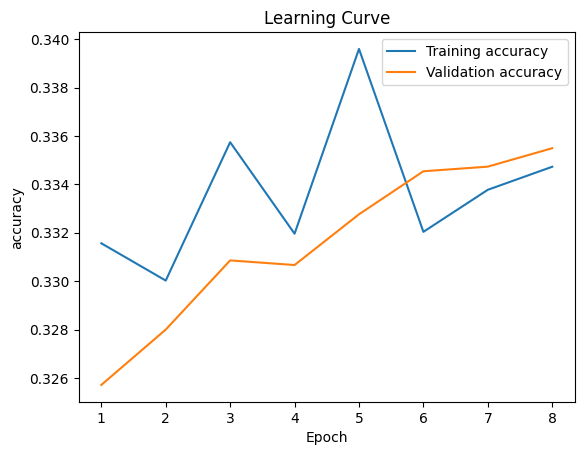

In [24]:
train_accuracy = []
valid_accuracy = []

train_f1 = []
valid_f1 = []

train_loss = []
valid_loss = []

for stats in training_stats:
    train_accuracy.append(stats['Training Accuracy'])
    valid_accuracy.append(stats['Validation Accuracy.'])
    train_loss.append(stats['Training Loss'])
    valid_loss.append(stats['Validation. Loss'])
    train_f1.append(stats['Training F1'])
    valid_f1.append(stats['Validation F1'])

LearningCurve(train_accuracy,valid_accuracy)

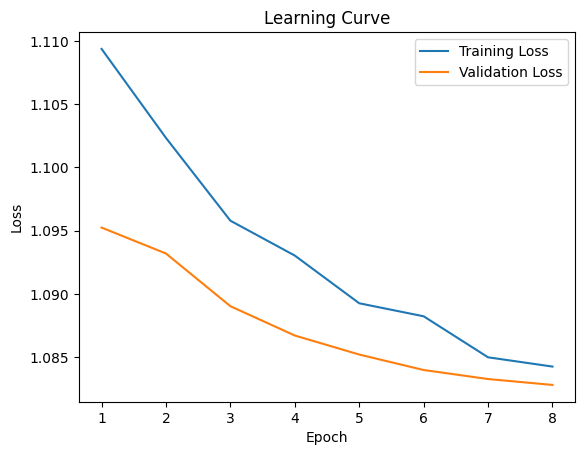

In [20]:
LearningCurve(train_loss,valid_loss,plot_label='Loss',y_label='Loss')

Predict on the test set

In [45]:
Predictions = []

with torch.no_grad(): #disable gradient caclulation since we are testing not training
    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)

        logits = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask,
                        return_dict=False)
        
        Predictions.append(logits[0].argmax(1).cpu().numpy())

Predictions = np.concatenate(Predictions)

Create Submsission file

In [46]:
#Create a dataframe based on a dictionary of the IDs and the predictions
y_test = pd.DataFrame(data={'Id': test_set['New_ID'], 'Predicted': Predictions})

#Convert the predicted labels [0,1,2] back to their corresponding labels [NEGATIVE,NEUTRAL,POSITIVE]
y_test['Predicted'] = y_test['Predicted'].apply(lambda x: labels.get(x,x))

#Save as csv
y_test.to_csv('sumbission.csv',index=False)